**线性支持向量机**用于分类任务，而**核支持向量机（SVM）**是可以推广到更复杂模型的，但无法被输入空间的超平面定义。

*虽然支持向量机可以同时用于分类和加归，一般SVC用于分类，SVR用于回归。*

In [1]:
# 在学习之前，先导入这些常用的模块
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mglearn

## 一、线性模型与非线性特征

**线性模型**在低维空间中可能非常受限，因为线和平面的灵性性有限。

有一种方法可以让线性模型更加灵活，就是添加更多的特征——举个例子，添加输入特征的交互项或多项式。

先看下面的例子，这是一幅二分类数据库集，其类别并不是线性可分的

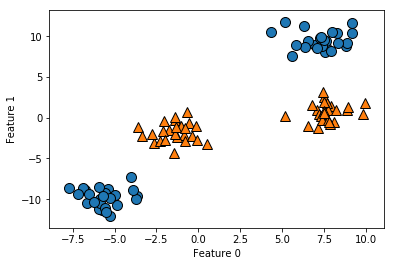

In [27]:
from sklearn.datasets import make_blobs
X, y = make_blobs(centers=4, random_state=8)
y = y % 2
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.show()

如果要对上例的数据强行进行线性划分的话，对这个数据集将无法给出较好的结果，如下图：

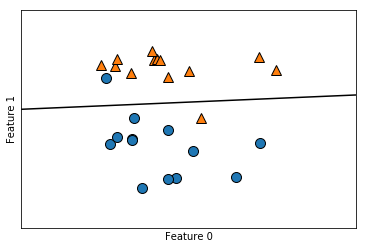

In [26]:
from sklearn.svm import LinearSVC
linear_svm = LinearSVC().fit(X, y)

mglearn.plots.plot_2d_separator(linear_svm, X)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.show()

可以看出，**SVM**无法对该数据集进行线性的分割，它感到很为难。

**现在对输入特征进行扩展，说添加第二个特征的平方（feature1 \*\* 2）作为一个新特征。现在我们将每个数据点表示为三维点（feature0, feature1, feature1\*\*2），而不是二维的点，如下图：**

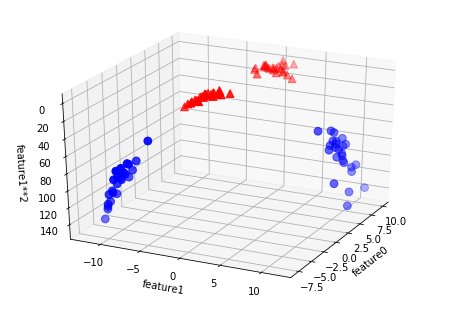

In [4]:
# 添加第二个特征的平方，作为一个新特征
X_new = np.hstack([X, X[:, 1:] ** 2])

# 如果你的anaconda上没有mpl_toolkits，可以通过 conda install mpl_toolkits进行安装
# 导入玩具数据的3D图展示模块
from mpl_toolkits.mplot3d import Axes3D, axes3d
# 创建一个幕布
figure = plt.figure()
# 创建3D可视化的绘图区
ax = Axes3D(figure, elev=-152, azim=-26)
# 首先画出所有 y == 0 的点，然后画出所有 y == 1 的点
mask = y == 0
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b', cmap=mglearn.cm2, s=60)
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^', cmap=mglearn.cm2, s=60)
ax.set_xlabel('feature0')
ax.set_ylabel('feature1')
ax.set_zlabel('feature1**2')
plt.show()

数据的三个特征在三维的空间里被展示出来，现在我们可以用线性模型拟合扩展的数据了：

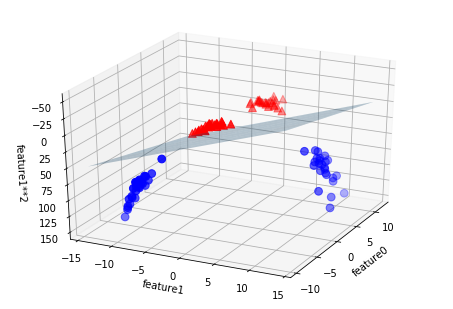

In [13]:
# 使用LinearSVC训练数据
linear_svm_3d = LinearSVC().fit(X_new, y)
# 获得模型的斜率集合与截距集合
coef, intercept = linear_svm_3d.coef_.ravel(), linear_svm_3d.intercept_

# 显示线性的决策边界
figure = plt.figure()
ax = Axes3D(figure, elev=-152, azim=-26)
xx = np.linspace(X_new[:, 0].min() - 2, X_new[:, 0].max() + 2, 50)
yy = np.linspace(X_new[:, 1].min() - 2, X_new[:, 1].max() + 2, 50)

XX, YY = np.meshgrid(xx, yy)
ZZ = (coef[0] * XX + coef[1] * YY + intercept) / -coef[2]
ax.plot_surface(XX, YY, ZZ, rstride=8, cstride=8, alpha=0.3)
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b', cmap=mglearn.cm2, s=60)
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^', cmap=mglearn.cm2, s=60)
ax.set_xlabel('feature0')
ax.set_ylabel('feature1')
ax.set_zlabel('feature1**2')
plt.show()

**SVM**对三维的数据近平面对等划划分，这是由线到面的一种改进。

如果将该3D图压缩成一张二维的图，将得出一个非线性的，而是椭圆的分界区，如下展示：

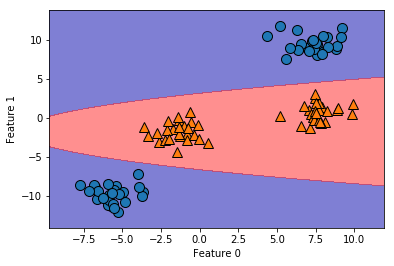

In [19]:
ZZ = YY ** 2
dec = linear_svm_3d.decision_function(np.c_[XX.ravel(), YY.ravel(), ZZ.ravel()])
plt.contourf(XX, YY, dec.reshape(XX.shape), levels=[dec.min(), 0, dec.max()], cmap=mglearn.cm2, alpha=.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.show()

通过将数据立体化，再进行分类，由于多出了一个维度，将能更好的找到各数据之间的界线！

## 二、核技巧

> 这里需要记住的是，向数据表示中添加非线性的特征，可以让线性模型变得更强大。但是通常来说我们并不知道要添加哪些特征，而且添加许多特征（比如100维特征空间所有可能的交互项）的计算开销可能会很大。幸运的是，有一种巧妙的数学技巧，让我们可以在更空间中学习分类器，而不是用实际计算可能非常大的新的数据表示。这种技巧叫作**核技巧**，它的原理是直接计算扩展特征表示中数据点之间的距离（更准确地说是内积），而不是实际对扩展进行计算。

> 对于支持向量机，将数据映射到更高维空间中有两种常用的方法：一种是多项式核，在一定除数内计算原始特征所有可能的多项式（比如 feature1 ** 2 * feature2 ** 5）；另一种是**径向基函数核(RBF核)**，也叫**高斯核**。高斯核有点难以解释，因为它对应无限维的特征空间。一种对高斯核的解释是它考虑所有阶数的所有可能的多项式，但阶数越高，特征的重要性越小。

> 不过在实践中，核SVM背后的数学细节并不重要，可以简单地总结出使用高斯核SVM进行预测的方法——将在以后进行介绍。

## 三、理解SVM

在训练过程中，**SVM**学习每个训练数据点对于表示两个类别之间的决策边界的重要性。通常只有一部分训练数据点对于定义决策边界来说很重要：位于类别之间边界上的那些点。这些点叫做**支持向量**，支持向量机正是由此得名。

想要对新样本点进行预测，需要测量它与每个支持向理之间的距离。分类决策是基于它与支持向量之间的距离以及在训练过程中学到的支持向量重要性（保存在 SVC 的 dua_coef_属性中）来做出的。

而数据点之间的距离由离斯核给出：

$k_{rbs}(x_1, x_2) = exp(-\gamma || x_1 - x_2 || ^2)$

这里 x1 和 x2 是数据点，$||x1 - x2||$表示欧氏距离， $\gamma$ 是控制高斯核宽度的参数。

**下图是支持向量机对一个二维二分类数据集的训练结果。决策边界用黑色表示，支持向量是较大的点。下列代码将在 forge 数据集上训练 SVM 并创建此图：**

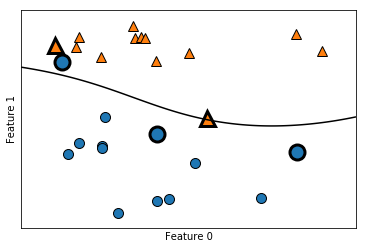

In [25]:
from sklearn.svm import SVC
X, y = mglearn.tools.make_handcrafted_dataset()
svm = SVC(kernel='rbf', C=10, gamma=0.1).fit(X, y)
mglearn.plots.plot_2d_separator(svm, X, eps=.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
# 画出支持向理
sv = svm.support_vectors_
# 支持向量的类别标签由dual_cofe_的正负号给出
sv_labels = svm.dual_coef_.ravel() > 0
mglearn.discrete_scatter(sv[:, 0], sv[:, 1], sv_labels, s=15, markeredgewidth=3)
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.show()

**SVM**给出了非常平滑且非常线性（不是直线）的边界。这时在我们调节了两个参数：C参数和gamma参数，下面我们将详细讨论。

## 四、SVM调参

- gamma 参数用于控制高斯核的宽度。它决定了点与点之间“靠近”是指多大距离。
- C 参数是正则化参数，与线性模型中用到的类似。这限制每个点的重要性（或者更确切的说，第个点的 dual_cofe_)。

接下来，通过图例来展示改变这两个参数时模型的表现：

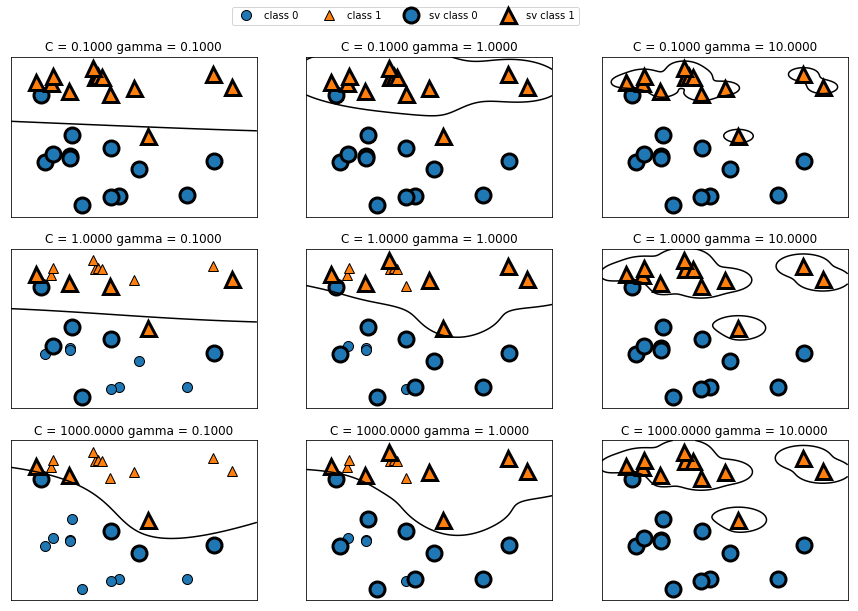

In [35]:
# 创建三个幕布，三个绘图区
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

# 指定三个C值
for ax, C in zip(axes, [-1, 0, 3]):
    # 指定三个gmma值
    for a, gamma in zip (ax, range(-1, 2)):
        # 绘图
        mglearn.plots.plot_svm(log_C=C, log_gamma=gamma, ax=a)

# 添加图例
axes[0, 0].legend(['class 0', 'class 1', 'sv class 0', 'sv class 1'], ncol=4, loc=(.9, 1.2))
plt.show()

黑色的线条是决策边界，大的数据点是支持向量。

观察上图得：

- 从左到右，gamma的值由0.1增加到10，越来越大。而决策边界与支持向量的距离从左到右越来越小，左侧的决策边界更平滑，右侧的决策边界更关注单个数据点，更复杂。结论是，gamma值越大，生成的模型越复杂。
- 从上到下，C 值从0.1增加到1000，上面的决策线比下面的更加平整，说明上面的模型受到的约束更大，而下面的决策线会更多的关注到单个的数据点，更自由一点，说明下面的模型受到的约束更小。结论是：C值越大，模型受到的约束越小。

再来看看将**SVM**运用到腺癌数据集上的效果。默认情况下，C=1, gamma=1/n_features:

In [42]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

svc = SVC()
svc.fit(X_train, y_train)

print('训练集评估结果：', svc.score(X_train, y_train))
print('测试集评估结果：', svc.score(X_test, y_test))

训练集评估结果： 1.0
测试集评估结果： 0.6293706293706294


这个结果表明，模型在训练集上存在过拟合的情况。

虽然**SVM**的表现通常都很好，但它对参数的设定和数据的缩放非常敏感。特别地，它要求所有特征有相似的变化范围。

我们来看一下每个特征的最小值和最大传下，它们绘制在对数坐标上：

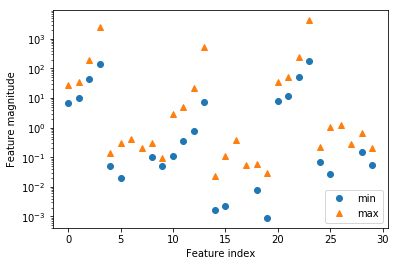

In [49]:
plt.plot(X_train.min(axis=0), 'o', label='min')
plt.plot(X_train.max(axis=0), '^', label='max')
plt.legend(loc=4)
plt.xlabel('Feature index')
plt.ylabel('Feature magnitude')
plt.yscale('log')
plt.show()

可以看出，乳腺癌数据集的特征具有完全不同的数量级。这对其他模型来说（比如线性模型）可能是小问题，但对核SVM却有极大影响。我们来研究蝁这个问题的几种方法：

## 五、为SVM预处理数据

解决方法之一是：对数据进行缩放，使其尽量在一个范围（0~1）之间。

代码如下：

In [52]:
# 计算训练集中每个特征的最小值
min_on_training = X_train.min(axis=0)
# 计算训练集中每个特征的范围（最大值-最小值）
range_on_training = (X_train - min_on_training).max(axis=0)

# 减去最小值，然后除以范围
# 这样每个特征都是min=0和max=1
X_train_scaled = (X_train - min_on_training) / range_on_training
print('最小值：', X_train_scaled.min(axis=0))
print('最大值：', X_train_scaled.max(axis=0))

最小值： [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
最大值： [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


In [53]:
# 利用训练集的最小值和范围对测试集做相同的变换
X_test_scaled = (X_test - min_on_training) / range_on_training

In [57]:
svc = SVC()
svc.fit(X_train_scaled, y_train)

print('训练集评估结果：', svc.score(X_train_scaled, y_train))
print('测试集评估结果：', svc.score(X_test_scaled, y_test))

训练集评估结果： 0.9483568075117371
测试集评估结果： 0.951048951048951


**数据缩放的作用如此之大！**但因为训练集与测试集的评估结果十分接近，说明模型还是存在欠拟合的情况。

现在尝试增大C或gamma来拟合更为复杂的模型：

In [58]:
svc = SVC(C=1000)
svc.fit(X_train_scaled, y_train)

print('训练集评估结果：', svc.score(X_train_scaled, y_train))
print('测试集评估结果：', svc.score(X_test_scaled, y_test))

训练集评估结果： 0.9882629107981221
测试集评估结果： 0.972027972027972


这里只增大的了C，模型的精度提高了！

### 总结：

- SVM很强大，即使只有几个特征，它也允许决策边界很复杂。
- 对样本的缩放不是很好，因为如果数量特别大的时候，其运行与表现将受到挑战。
- SVM参数的调整，对于我们来说也是个挑战，有时候很难对SVM做出合理的检查。